In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

from functools import partial
from pathlib import Path

import jax
import jax.numpy as jnp
import orbax
import orbax.checkpoint

import utils.file_processing as fp
from ddpg import DDPG
from envs.KS_environment_jax import KSenv
from utils import file_processing as fp

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from fun_mf_results import generate_DA_RL_episode

## Define config, environment, agent

In [2]:
# define config, env, agent, model, key
# replace with the experiment path
experiment_path = Path('local_results/KS/run_20250128_142853')

config = fp.load_config(experiment_path)
# load model weights
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
weights_path = experiment_path / 'models' / 'best_model'
params_dict = orbax_checkpointer.restore(weights_path.absolute())
params = params_dict["actor"]["target_params"]

# generate keys for running experiments
key = jax.random.PRNGKey(config.seed)
_, key_experiment = jax.random.split(key)

# create environment
env = KSenv(**config.env)

# create agent
agent = DDPG(config, env)

/home/do521/DA-RL/.venv/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## Get episode generator

In [3]:
random_episode, act_episode = generate_DA_RL_episode(config, env, agent, key_experiment)

## Plotting functions

In [4]:
def get_plotting_data(
    env,
    true_state_arr,
    true_obs_arr,
    unfilled_obs_arr,
    wait_steps,
    observation_starts,
):
    x = env.ks_solver.x
    x_obs = env.observation_locs
    x_act = env.actuator_locs * (env.ks_solver.L / (2 * jnp.pi))

    # fill the observations
    obs_arr = jnp.nan * jnp.ones_like(true_obs_arr)
    for i in range(len(obs_arr)):
        obs_arr = obs_arr.at[wait_steps * i + observation_starts].set(
            unfilled_obs_arr[i]
        )

    # get fourier coefficients
    true_state_arr_f = jnp.fft.rfft(true_state_arr, axis=1)
    mag_state_arr = 2 / env.N * jnp.abs(true_state_arr_f)


    return (x, x_obs, x_act,
            true_state_arr,
            mag_state_arr,
            true_obs_arr,
            obs_arr,
            )

In [5]:
plt.style.use("utils/stylesheet.mplstyle")

# set the colours
from utils import custom_colormap
my_cmap = custom_colormap.create_custom_colormap(type="discrete")
true_color = my_cmap(0)
noisy_color = "red"
model_color = my_cmap(2)
ensemble_color = "plum"
action_color = "lightskyblue"

In [6]:
# plotting function
def plot_episode(
    x,
    x_obs,
    x_act,
    full_state_arr,
    true_obs_arr,
    obs_arr,
    mag_state_arr,
    reward_arr,
    action_arr,
    add_inset=False,
    annotate_bottom = ['']
):  
    # initialize figure
    fig = plt.figure(layout="constrained", figsize=(10, 6))
    subfigs = fig.subfigures(1, 2)
    # PANEL A: TRUTH | RECON | ERROR
    axs0 = subfigs[0].subplots(
        3,
        1,
    )
    # PANEL B: FOURIER | OBSERVATION | ACTION
    axs1 = subfigs[1].subplots(4,1)
    fourier_idx = 3
    obs_idx = 0
    act_idx = 0

    titles = list(map(chr, range(ord('a'), ord('z')+1)))
    k = 0

    # PANEL A: TRUTH | RECON | ERROR
    # plot the full state and reward
    im = axs0[0].imshow(
        full_state_arr.T,
        extent=[0, len(full_state_arr), x[0], x[-1]],
        origin="lower",
        aspect="auto",
        cmap="seismic",
    )
    x_obs = [0, env.ks_solver.L/4, env.ks_solver.L/2, 3*env.ks_solver.L/4]
    x_obs_str = ["0", "L/4", "L/2", "3L/4",]
    x_obs_str_ = ["$0$", "$L/4$", "$L/2$", "$3L/4$"]
    axs0[0].set_yticks(x_obs)
    axs0[0].set_yticklabels(x_obs_str_)
    axs0[0].set_xticklabels([])
    axs0[0].set_ylabel("$x$")
    cbar = fig.colorbar(im, ax=[axs0[0]], location="left", pad=0.02)
    cbar.ax.set_ylabel("$u$", rotation=90, labelpad=15, va="center")
    # plot the state that actor-critic receives
    non_nan_idxs = jnp.where(~jnp.isnan(obs_arr))
    non_nan_obs = obs_arr[non_nan_idxs]
    non_nan_obs = non_nan_obs.reshape(
        non_nan_obs.shape[0] // obs_arr.shape[1], obs_arr.shape[1]
    )
    # concatenate with nans for the unobserved part
    nan_arr = jnp.nan * jnp.ones((config.enKF.observation_starts // config.enKF.wait_steps, obs_arr.shape[1]))
    stacked_obs = jnp.vstack((nan_arr, non_nan_obs))
    im = axs0[1].imshow(
        stacked_obs.T,
        extent=[0, len(stacked_obs), x[0], x[-1]],
        origin="lower",
        aspect="auto",
        cmap="seismic",
    )
    axs0[1].set_xticklabels([])
    axs0[1].set_yticks(x_obs)
    axs0[1].set_yticklabels(x_obs_str_)
    axs0[1].set_ylabel("$x$")
    cbar = fig.colorbar(im, ax=[axs0[1]], location="left", pad=0.02)
    cbar.ax.set_ylabel("$o$", rotation=90, labelpad=15, va="center")

    # Add triangles on x_act locations on the right y axis
    for act in x_act:
        axs0[0].plot(1.0, act, marker="<", color="black", markersize=6, transform=axs0[0].get_yaxis_transform(), clip_on=False)
        axs0[1].plot(1.0, act, marker="<", color="black", markersize=6, transform=axs0[1].get_yaxis_transform(), clip_on=False)
    x_act_str = ["0", "L/8", "L/4", "3L/8", "L/2", "5L/8", "3L/4", "7L/8"]

    # plot the error between true and reconstruction
    err2 = jnp.abs(env.target[:, None] - full_state_arr.T)
    im = axs0[2].imshow(
        err2,
        extent=[0, len(full_state_arr), x[0], x[-1]],
        origin="lower",
        aspect="auto",
        cmap="Greens",
    )
    axs0[2].set_yticks(x_obs)
    axs0[2].set_yticklabels(x_obs_str_)
    axs0[2].set_ylabel("$x$")
    cbar = fig.colorbar(im, ax=[axs0[2]], location="left", pad=0.02)
    cbar.ax.set_ylabel("$|u-u_t|$", rotation=90, labelpad=15, va="center")
    axs0[2].set_xlabel("Episode steps $[t]$")
    for ax in axs0:
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))  # n=2 means 1 minor tick between major ticks
        ax.tick_params(axis='x', which='minor', length=4, color='black')
        if titles[k] in annotate_bottom:
            ax.annotate(f"({titles[k]})", xy=(0.02, 0.15), xycoords="axes fraction")
        else:
            ax.annotate(f"({titles[k]})", xy=(0.02, 0.85), xycoords="axes fraction")
        k += 1
    # PANEL B: FOURIER | OBSERVATION | ACTION
    axs1[0].plot(mag_state_arr[:, fourier_idx], color=true_color, linewidth=2.5, label=f"$|c_{{{fourier_idx}}}|$")
    axs1[0].set_ylabel(f"$|c_{{{fourier_idx}}}|$")
    axs1[0].set_xticklabels([])
    axs1[0].legend(ncols=2, frameon=False, handletextpad=0.5, columnspacing=0.5, handlelength=1.5)

    axs1[1].plot(true_obs_arr[:, obs_idx], color=true_color, linewidth=2.5, label='$u$')
    axs1[1].plot(obs_arr[:, obs_idx],
                 marker="o",
                 linestyle="",
                 markersize=1.5,
                 color=noisy_color,
                 label='$o$'
                 )
    axs1[1].set_ylabel(f"$u(x={x_obs_str[obs_idx]})$")
    axs1[1].set_xticklabels([])
    axs1[1].legend(loc="lower right", ncols=3, frameon=False, handletextpad=0.5, columnspacing=0.5, handlelength=1.5, bbox_to_anchor=(1.0,-0.08))

    if add_inset == True:
        # # Add inset axes
        ylims = axs1[1].get_ylim()
        axs1[1].set_ylim([ylims[0], ylims[1] + 1. ])
        # Define inset position in data coordinates
        x0, y0, width, height = 750, 0.5, 750, 3.0  # Adjust as needed
        # Convert data coordinates to display coordinates
        disp_coords = axs1[1].transData.transform([(x0, y0), (x0 + width, y0 + height)])

        # Convert display coordinates to axis-relative coordinates
        ax_coords = axs1[1].transAxes.inverted().transform(disp_coords)

        # Extract normalized coordinates
        x_frac, y_frac = ax_coords[0]
        width_frac, height_frac = ax_coords[1] - ax_coords[0]

        # Create inset axes
        ax_inset = axs1[1].inset_axes([x_frac, y_frac, width_frac, height_frac])
        # ax_inset = axs1[1].inset_axes([0.52, 0.5, 0.47, 0.45])
        ax_inset.plot(true_obs_arr[:, obs_idx], color=true_color, linewidth=2.5, label="$u$")
        ax_inset.plot(
            obs_arr[:, obs_idx],
            marker="o",
            linestyle="",
            markersize=1.5,
            color=noisy_color,
            label="$o$",
        )
        ax_inset.set_xlim(x0, x0+width)
        ax_inset.set_xticklabels([])
        ax_inset.set_ylim(-0.2, -0.01)
        for label in ax_inset.get_yticklabels():
            label.set_fontsize(12)
        ax_inset.grid('on')

    # plot the actuation
    axs1[2].plot(action_arr[:,act_idx], color=action_color, linewidth=1.0)
    axs1[2].set_ylabel(f"$a(x={x_act_str[act_idx]})$")
    axs1[2].set_xticklabels([])

    # plot the reward
    axs1[3].plot(reward_arr, '-', color=true_color, linewidth=2.5, label='True')
    axs1[3].set_ylabel("$r(\mathbf{u},\mathbf{a})$")
    axs1[3].set_xlabel("Episode steps $[t]$")
    axs1[3].legend(ncols=2, frameon=False, handletextpad=0.5, columnspacing=0.5, handlelength=1.5)

    for ax in axs1:
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=3))  # Ensure 3 ticks
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1f}'))
        # Set AutoMinorLocator to only place ONE minor tick
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))  # n=2 means 1 minor tick between major ticks
        ax.tick_params(axis='x', which='minor', length=4, color='black')
        # Enable grid for major and minor ticks
        ax.grid(True, which='major', linestyle='-', linewidth=0.3, color='gray')  # Major grid
        ax.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')  # Minor grid
        if titles[k] in annotate_bottom:
            ax.annotate(f"({titles[k]})", xy=(0.02, 0.15), xycoords="axes fraction")
        else:
            ax.annotate(f"({titles[k]})", xy=(0.02, 0.75), xycoords="axes fraction")
        k += 1
    return fig

## Initialise episode with random seed

In [ ]:
# set random seed for episode initialisation, observation noise, and actions if random episode
seed = 50
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4) 

## Generate random episode

In [8]:
# generate a random episode
(
    true_state_arr,
    true_obs_arr,
    unfilled_obs_arr,
    action_arr,
    reward_arr,
    _,_,_
)  = random_episode(key_env, key_obs, key_action)

(x, x_obs, x_act, 
true_state_arr,
mag_state_arr,
true_obs_arr,
obs_arr,
) = get_plotting_data(
                      env,
                      true_state_arr,
                      true_obs_arr,
                      unfilled_obs_arr,
                      config.enKF.wait_steps,
                      config.enKF.observation_starts,
                      )

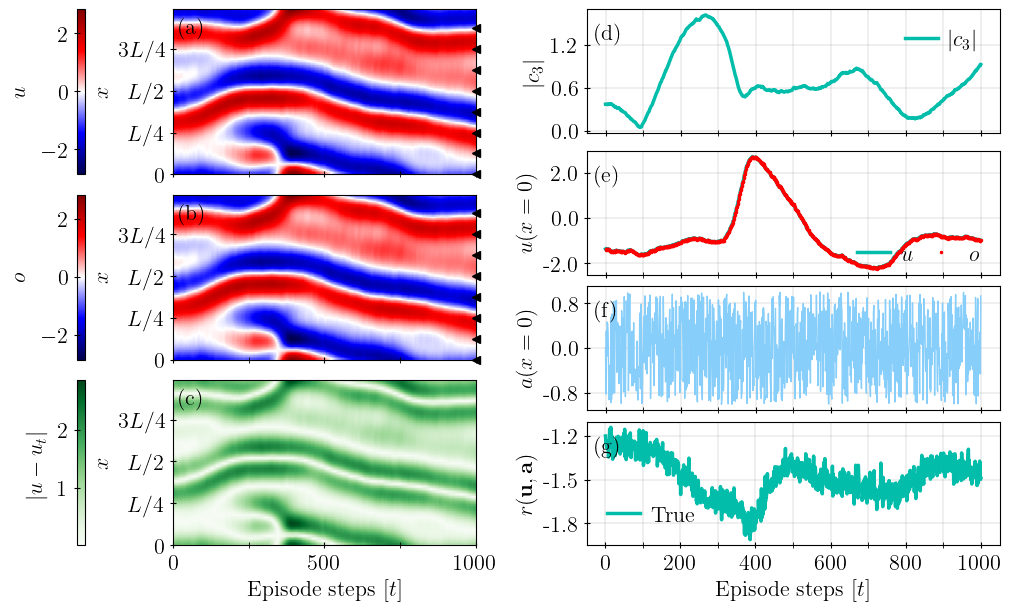

In [10]:
# plot the episode
fig = plot_episode(
    x,
    x_obs,
    x_act,
    true_state_arr,
    true_obs_arr,
    obs_arr,
    mag_state_arr,
    reward_arr,
    action_arr,
)
# fig.savefig('fig_mf_random_ep.png', bbox_inches="tight")
# fig.savefig('fig_mf_random_ep.pdf', bbox_inches="tight")

## Generate controlled episode

In [11]:
# generate an act/controlled episode
(
    true_state_arr,
    true_obs_arr,
    unfilled_obs_arr,
    action_arr,
    reward_arr,
    _,_ 
)  = act_episode(key_env, key_obs, params=params)

(x, x_obs, x_act, 
true_state_arr,
mag_state_arr,
true_obs_arr,
obs_arr,
) = get_plotting_data(
                      env,
                      true_state_arr,
                      true_obs_arr,
                      unfilled_obs_arr,
                      config.enKF.wait_steps,
                      config.enKF.observation_starts,
                      )

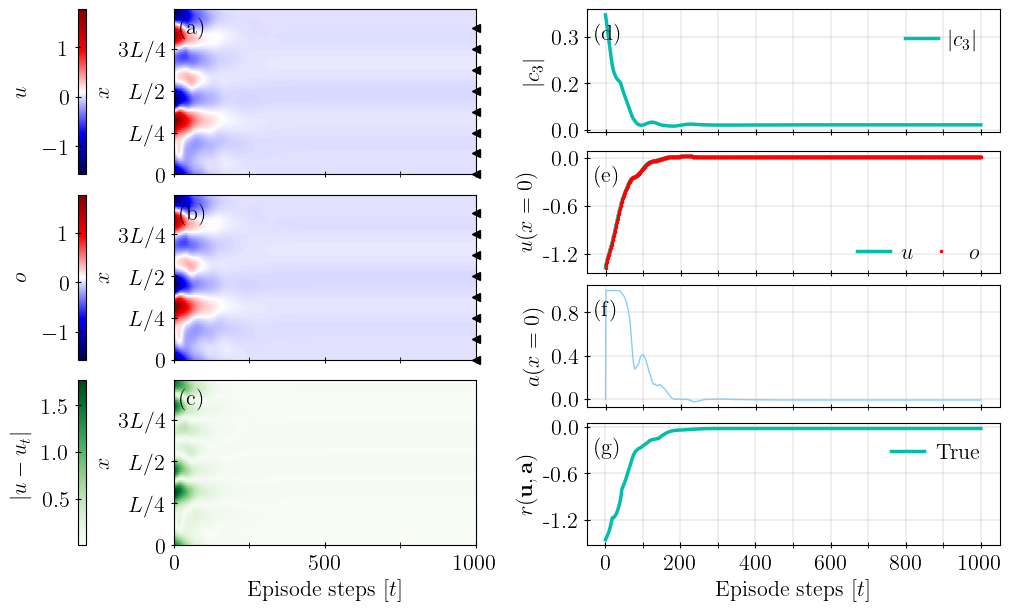

In [13]:
# plot the episode
fig = plot_episode(
    x,
    x_obs,
    x_act,
    true_state_arr,
    true_obs_arr,
    obs_arr,
    mag_state_arr,
    reward_arr,
    action_arr,
)
# fig.savefig('fig_mf_controlled_ep.png', bbox_inches="tight")
# fig.savefig('fig_mf_controlled_ep.pdf', bbox_inches="tight")

## Get the statistics of control performance in evaluation

In [4]:
# Get the statistics of control performance in evaluation
# Model weights are stored locally
import pandas as pd
import wandb
api = wandb.Api()
results_folder = Path("local_results/KS")
project_name = "DA-RL-MF"
esn_hyp_file_name_arr = []  # Store all runs in this group

seed = 50
n_test_episodes = 20
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4)

# Define batched random keys for parallel processing
key_env, subkey_env = jax.random.split(key_env)
key_obs, subkey_obs = jax.random.split(key_obs)
key_action, subkey_action = jax.random.split(key_action)

# Create batched keys for all episodes
batch_keys_env = jax.random.split(subkey_env, n_test_episodes)
batch_keys_obs = jax.random.split(subkey_obs, n_test_episodes)
batch_keys_action = jax.random.split(subkey_action, n_test_episodes)

def retrieve_test_returns(group_idx_arr):
    results = []
    for group_idx in group_idx_arr:
        runs = api.runs(
            f"defneozan/{project_name}",
            {"$and": [{"group": f"{group_idx}"}]},
            )
        for run_idx, run in enumerate(runs):
            results_path = Path(results_folder / run.config["local_path"])
            config = fp.load_config(results_path)

            orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
            weights_path = results_path / 'models' / 'best_model'
            params_dict = orbax_checkpointer.restore(weights_path.absolute())
            params = params_dict["actor"]["target_params"]

            # generate keys for running experiments
            key = jax.random.PRNGKey(config.seed)
            _, key_experiment = jax.random.split(key)

            # create environment
            env = KSenv(**config.env)
            n_sensors = len(env.observation_inds)

            # create agent
            agent = DDPG(config, env)
            random_episode, act_episode = generate_DA_RL_episode(config, env, agent, key_experiment)
            
            p_act_episode = partial(act_episode, params=params)
            # Use vmap to process all episodes in parallel
            batched_results = jax.vmap(p_act_episode)(batch_keys_env, batch_keys_obs)
            # Unpack results
            (
                true_state_arrs,
                _,
                _,
                _,
                reward_arrs,
                _, _ # Keys can be ignored if not needed further
            ) = batched_results
            
            final_u_norms = [float(jnp.sqrt(1/len(arr[-1])) * jnp.linalg.norm(arr[-1])) for arr in true_state_arrs]
            returns = [float(jnp.sum(arr[config.enKF.observation_starts + 1 :])) for arr in reward_arrs]
        for episode_idx in range(n_test_episodes):
            results.append({
                    "group_idx": group_idx,
                    "run_idx": run_idx,
                    "episode_idx": episode_idx,
                    "n_sensors": n_sensors,
                    "final_u_norm": final_u_norms[episode_idx],
                    "return_env": returns[episode_idx],
                })
    return pd.DataFrame(results)

In [5]:
group_idx_arr =  [0, 2, 3, 4, 5, 6]
df_all_results = retrieve_test_returns(group_idx_arr)

/home/do521/DA-RL/.venv/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
/home/do521/DA-RL/.venv/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
/home/do521/DA-RL/.venv/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Co

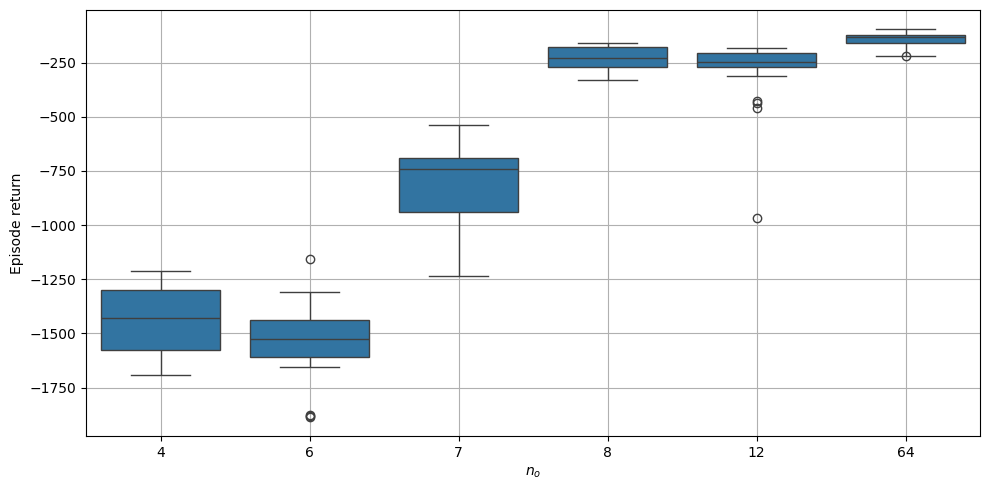

In [8]:
# Plot or filter:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_all_results, x="n_sensors", y="return_env")

plt.xlabel("$n_o$")
plt.ylabel("Episode return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
df_all_results.groupby("n_sensors")["return_env"].mean()

n_sensors
4    -1434.498472
6    -1541.610235
7     -799.375215
8     -229.852762
12    -301.509899
64    -145.469229
Name: return_env, dtype: float64